# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit,
                           plot_distance_weights,
                           plot_sim_results,
                           plot_parameters_kde)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [6]:
from channels.ina_generic import ina as model
model.sample({})

,x,y,exp
0,-90.000000,-4.357286e-06,0
1,-80.000000,-2.174741e-04,0
2,-70.000000,-3.897263e-03,0
3,-60.000000,-1.404948e-01,0
4,-50.000000,-3.767328e+00,0
5,-40.000000,-4.198874e+01,0
6,-30.000000,-1.310792e+02,0
7,-20.000000,-9.949035e+01,0
8,-10.000000,-9.254996e+01,0
9,0.000000,-8.155845e+01,0


# Get experimental measurements

In [7]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [8]:
limits = dict(g_Na=(0, 100),
              Vhalf_m=(-500,500),
              k_m=(0,50),
              c_bm=(0,50),
              c_am=(0,50),
              Vmax_m=(-200,200),
              sigma_m=(0,500),
              Vhalf_h=(-200,200),
              k_h=(-50,0),
              c_bh=(0,50),
              c_ah=(0,50),
              Vmax_h=(-500,500),
              sigma_h=(0,500),
              c_bj=(0,50),
              c_aj=(0,50),
              Vmax_j=(-500,500),
              sigma_j=(0,500))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [9]:
parameters = ['ina.'+k for k in limits.keys()]

In [10]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

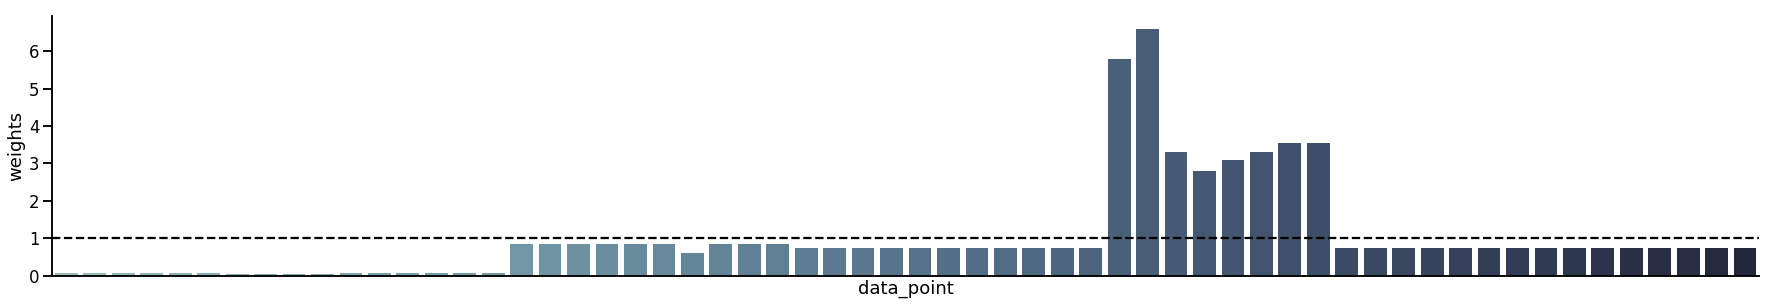

In [11]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)
g.savefig('results/ina-generic/dist_weights.pdf')

In [12]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.05,
    n_samples=1000)

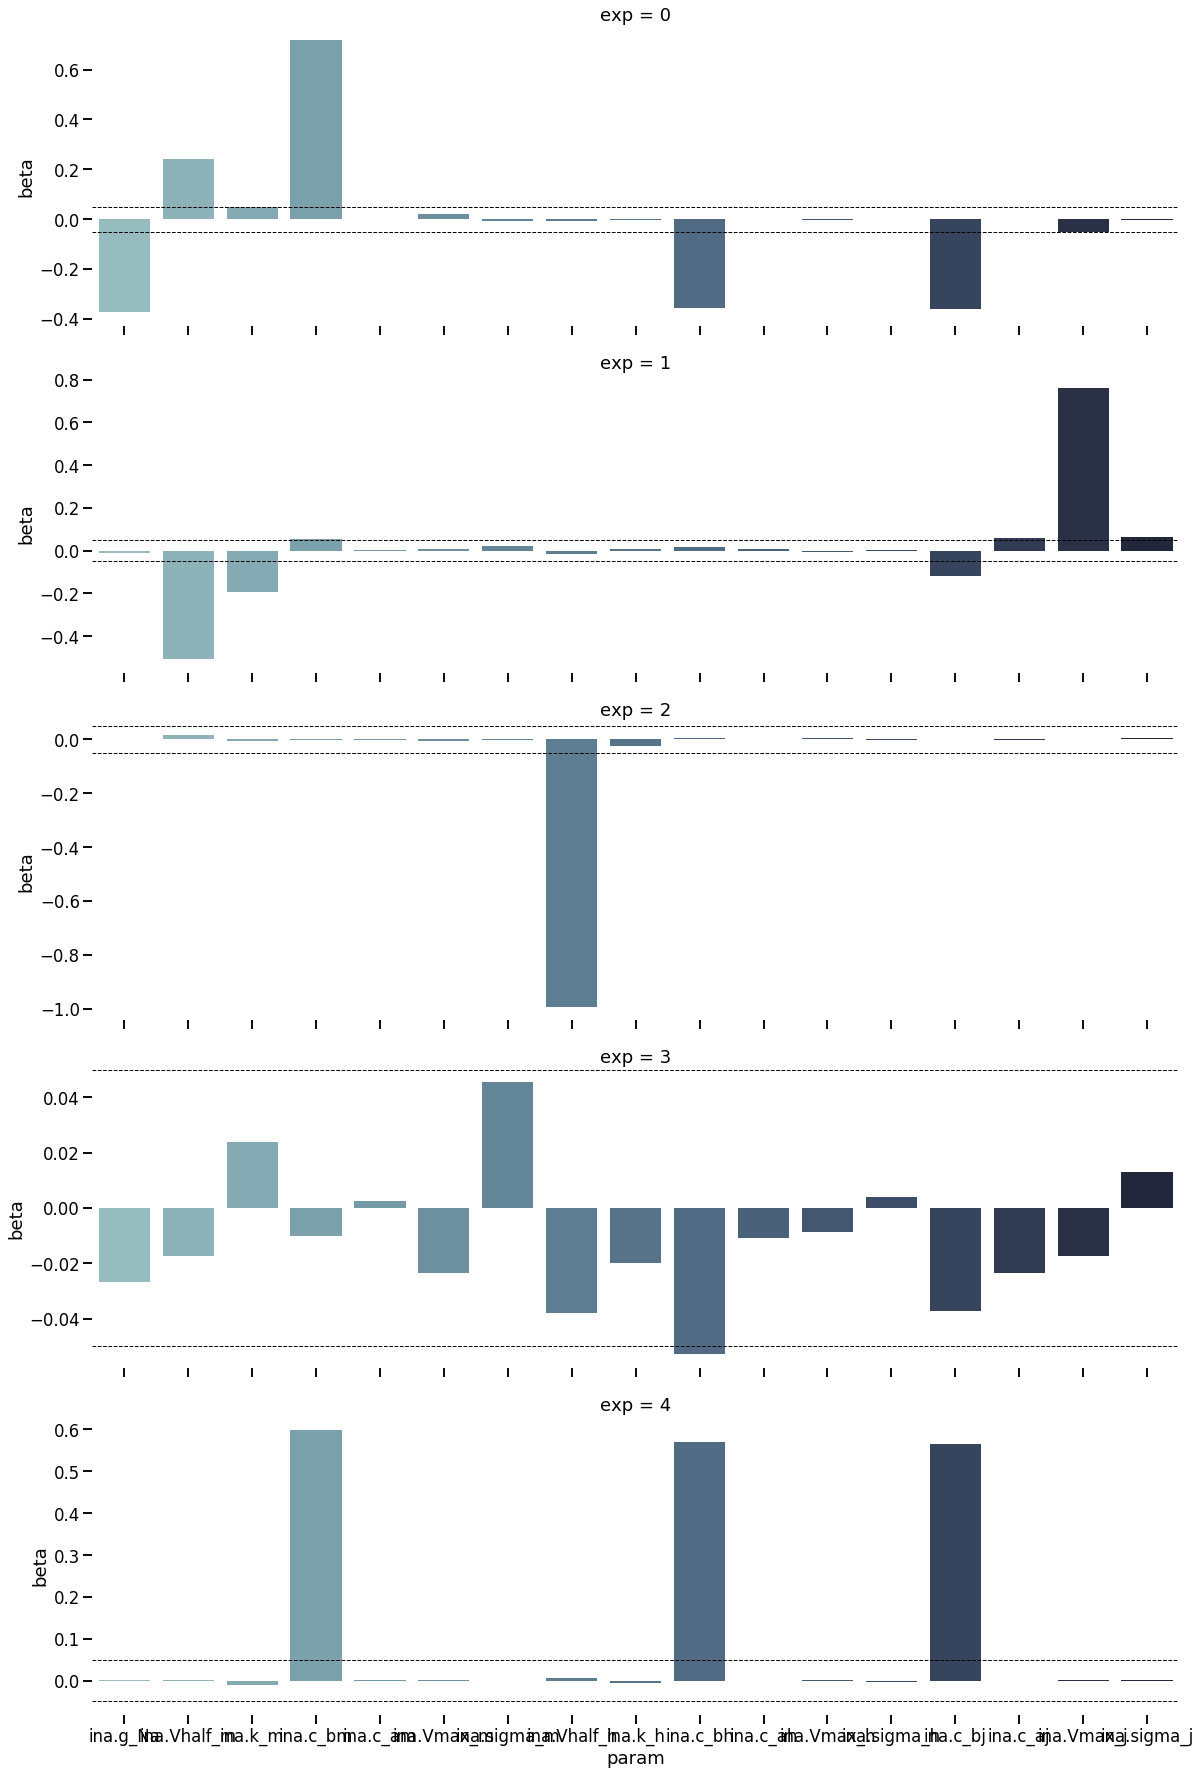

In [13]:
sns.set_context('talk')
grid1 = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

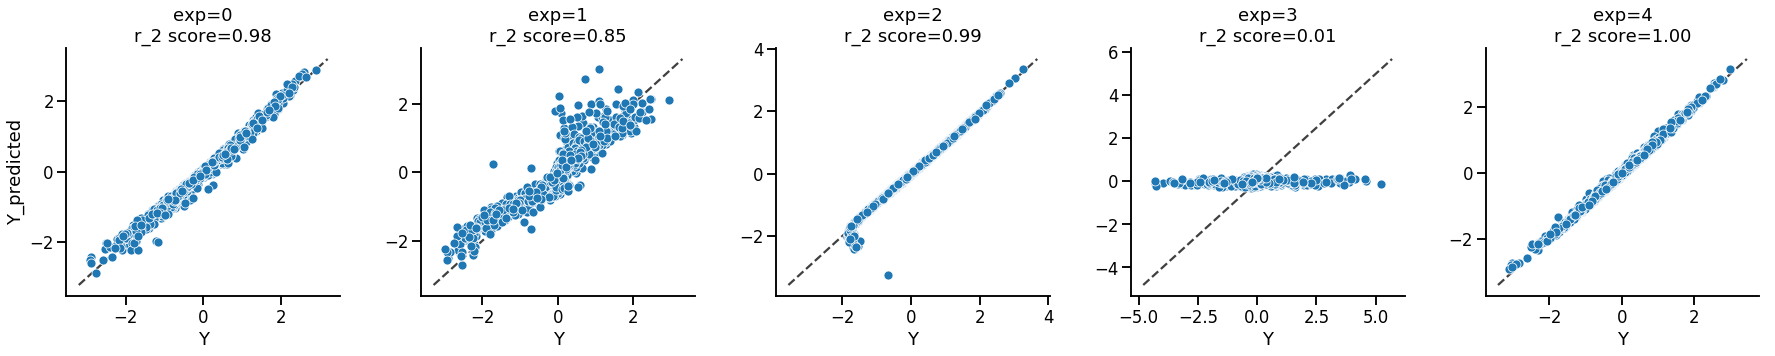

In [14]:
grid2 = plot_regression_fit(regression_fit, r2)

In [15]:
grid1.savefig('results/ina-generic/sensitivity.pdf')
grid2.savefig('results/ina-generic/sensitivity_fit.pdf')

In [16]:
# Finding insensitive parameters
cutoff = 0.05
fitted_pivot = fitted.pivot(index='param',columns='exp')
insensitive_params = fitted_pivot[(abs(fitted_pivot['beta'][0])<cutoff) & (abs(fitted_pivot['beta'][1])<cutoff) &
             (abs(fitted_pivot['beta'][2])<cutoff) & (abs(fitted_pivot['beta'][3])<cutoff) &
             (abs(fitted_pivot['beta'][4])<cutoff)].index.values

In [18]:
insensitive_limits = dict((k, limits[k[4:]]) for k in insensitive_params)
insensitive_prior = Distribution(**{key: RV("uniform", a, b - a)
                                 for key, (a,b) in insensitive_limits.items()})

In [19]:
# Generate random samples for insensitive parameters
def generate_sample(insensitive_prior, n):
    samples = [dict() for i in range(n)]
    for i in range(n):
        parameters = insensitive_prior.rvs()
        sample = {key: value for key, value in parameters.items()}
        samples[i].update(sample)
    return samples

In [20]:
samples = generate_sample(insensitive_prior, 1000)

In [21]:
model.add_external_par_samples(samples)

In [23]:
limits = dict((k, limits[k]) for k in limits if k[4:] not in insensitive_params)

In [25]:
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [26]:
"""
limits = dict(g_Na=(0, 100),
              p1=(0, 100),
              p2=(-100, 0),
              p3=(-10, 10),
              p4=(0, 1000),
              q1=(0, 100),
              q5=(-100, 0),
              q11=(0, 1.0),
              q13=(0, 1),
              r8=(0, 100),
              r11=(0, 10),
              r12=(-1, 1),
              r13=(0, 1),
              r16=(0, 100))
"""

'\nlimits = dict(g_Na=(0, 100),\n              p1=(0, 100),\n              p2=(-100, 0),\n              p3=(-10, 10),\n              p4=(0, 1000),\n              q1=(0, 100),\n              q5=(-100, 0),\n              q11=(0, 1.0),\n              q13=(0, 1),\n              r8=(0, 100),\n              r11=(0, 10),\n              r12=(-1, 1),\n              r13=(0, 1),\n              r16=(0, 100))\n'

# Initialise pyabc database

In [27]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ina-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ina-generic.db


In [28]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [29]:
from pyabc.populationstrategy import ConstantPopulationSize

In [30]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(5000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.05482047444775661, 1: 0.05482047444775661, 2: 0.05482047444775661, 3: 0.05482047444775661, 4: 0.05482047444775661, 5: 0.05482047444775661, 6: 0.04793030963340064, 7: 0.04260405991323703, 8: 0.0479278046958729, 9: 0.0536798519659175, 10: 0.05482047444775661, 11: 0.05482047444775661, 12: 0.05482047444775661, 13: 0.05482047444775661, 14: 0.05482047444775661, 15: 0.05482047444775661, 16: 0.8326197611814873, 17: 0.8326197611814873, 18: 0.8326197611814873, 19: 0.8326197611814873, 20: 0.8326197611814873, 21: 0.8326197611814873, 22: 0.6017669628485173, 23: 0.8326197611814873, 24: 0.8326197611814873, 25: 0.8326197611814873, 26: 0.7463215252566501, 27: 0.7463215252566501, 28: 0.7463215252566501, 29: 0.7463215252566501, 30: 0.7463215252566501, 31: 0.7463215252566501, 32: 0.7463215252566501, 33: 0.7463215252566501, 34: 0.7463215252566501, 35: 0.7463215252566501, 36: 0.7463215252566501, 37: 5.779317930650152, 38: 6.604934777885866, 39: 3.3021281756664393, 40: 2.

In [31]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2018-11-16 12:14:19.864925, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 23.62237341301505


In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:23.62237341301505
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 10103
DEBUG:Epsilon:new eps, t=1, eps=20.58008396473644
INFO:ABC:t:1 eps:20.58008396473644
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/smc.py:735: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
DEBUG:ABC:now s

In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.01)

# Results analysis

In [28]:
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_ina-generic.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-14 17:47:52.160619, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-11-14 20:24:20.598176, end_time=2018-11-14 23:46:45.437405)>,
 <ABCSMC(id=3, start_time=2018-11-15 08:58:03.290662, end_time=None)>]

In [29]:
history.id = 3

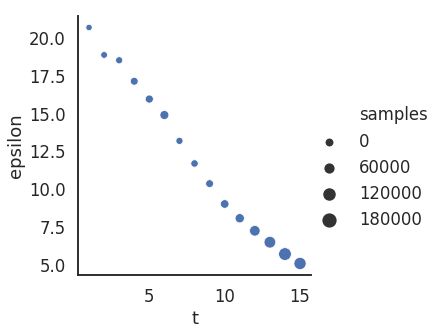

In [30]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=1])
#grid.savefig('results/ina/eps_evolution.pdf')

In [15]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


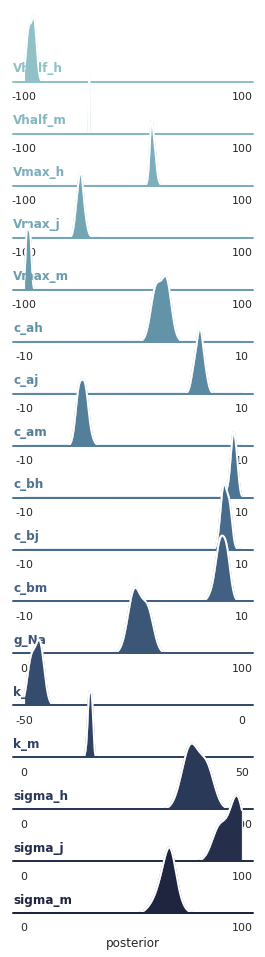

In [16]:
g = plot_parameters_kde(df, w, limits, aspect=5, height=.8)

In [17]:
#g.savefig('results/ina/parameters_kde.pdf')

# Samples for quantitative analysis

In [18]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [19]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


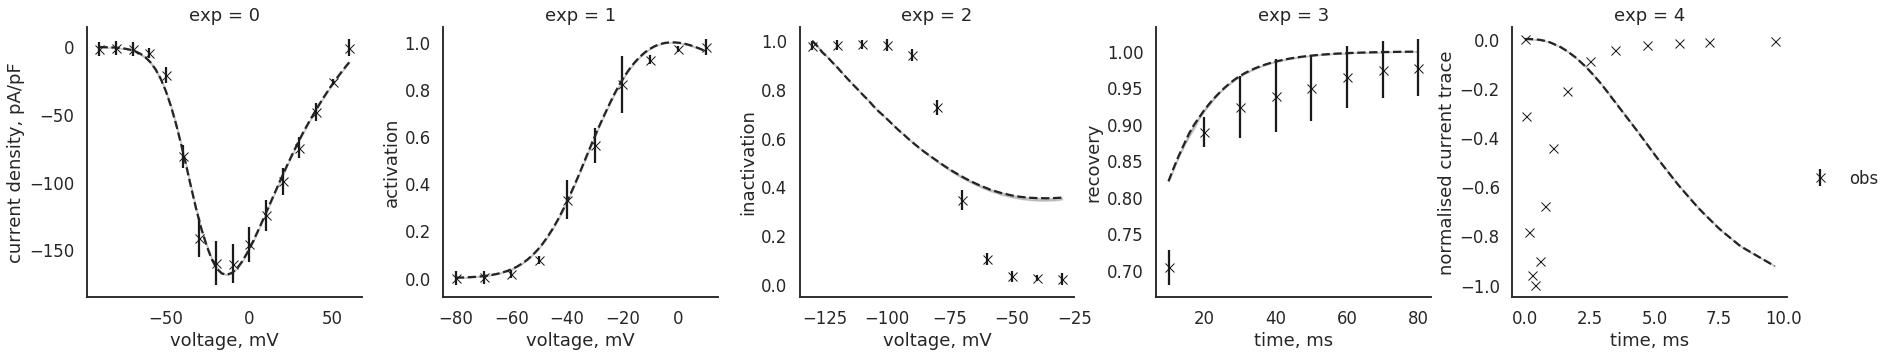

In [20]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current trace"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [27]:
g.savefig('results/ina/ina_sim_results.pdf')

In [28]:
# Require discrete samples for exact measurements at -20mV
discrete_samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    discrete_samples = discrete_samples.append(output, ignore_index=True)

In [29]:
# Amplitude at -20 mV
grouped = discrete_samples[discrete_samples['exp']==0].groupby('sample')
def get_amplitude(group):
    return group.loc[group.x==-20]['y']
print(grouped.apply(get_amplitude).mean())
print(grouped.apply(get_amplitude).std())

-160.90196264352795
5.971638842006106
The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [31]:
import scipy.stats as st
peak_current = discrete_samples[discrete_samples['exp']==0].groupby('sample').apply(get_amplitude).tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -160.49427334631037
95% CI: (-173.4232959055239, -149.88858494085878)


In [32]:
# Voltage and slope factor at half-activation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [33]:
print(output.mean())
print(output.std())

0   -35.198870
1     7.077036
dtype: float64
0    1.077150
1    0.895428
dtype: float64


In [34]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -35.297432069439395
95% CI: (-37.16992916736465, -33.00366784635306)


In [35]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.0123915573204245
95% CI: (5.335717755624719, 8.748525607464313)


In [36]:
# Voltage and slope factor at half-inactivation
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [37]:
print(output.mean())
print(output.std())

0   -70.387098
1     5.516439
dtype: float64
0    16.941384
1     0.699928
dtype: float64


In [38]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -73.05940272441362
95% CI: (-100.18293538638304, -34.65451029256239)


In [39]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.194922877406126
95% CI: (4.403575801992869, 6.9820518074314295)
